<a href="https://colab.research.google.com/github/vladimiralencar/DeepLearning-LANA/blob/master/DNN/DNN_03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Toolkit - Funções de Visualização

In [1]:
from google.colab import files
files.upload()
!mkdir data
!mkdir images
!cp *.csv data
!cp *.png images
!cp *.gif images

Saving saddle_point_evaluation_optimizers.gif to saddle_point_evaluation_optimizers (1).gif
Saving z-score.png to z-score (1).png
Saving one-hot.png to one-hot (1).png
Saving tanh.png to tanh (1).png
Saving higher-dimensions-classification.png to higher-dimensions-classification (1).png
Saving binary-classification.png to binary-classification (1).png
Saving abstract_nn.png to abstract_nn (1).png
Saving ann_class_reg.png to ann_class_reg (1).png
Saving ann.png to ann (1).png
Saving bias_value.png to bias_value (1).png
Saving bias_weight.png to bias_weight (1).png
Saving contours_evaluation_optimizers.gif to contours_evaluation_optimizers (1).gif
Saving deriv_sigmoid.png to deriv_sigmoid (1).png
Saving deriv.png to deriv (1).png
Saving errors.png to errors (1).png
Saving kfold.png to kfold (1).png
Saving momentum.png to momentum (1).png
Saving relu.png to relu (1).png
Saving roc.png to roc (1).png
Saving sgd_error.png to sgd_error (1).png
Saving sigmoid.png to sigmoid (1).png
Saving spe

## Classificação Binária, Classificação Multiclasse e Regressão

* **Classificação Binária** - Classificação entre duas possibilidades (positiva e negativa). Comum em testes médicos: a pessoa tem a doença (positiva) ou não (negativa).
* **Classificação Multiclasse** - Classificação entre mais de 2 classes. Como exemplo, o conjunto de dados da íris (classificação de 3 espécies de flores).
* **Regressão** - Previsão numérica. Como exemplos as previsões de MPG de um automóvel.

Neste Jupyter Notebook, veremos algumas visualizações para os três tipos de aprendizagens acima.

## Funções Auxiliares

É uma boa prática criar suas próprias funções de limpeza e transformação dos dados que serão processados pelo modelo de rede neural. Use esses exemplos como referência.

In [0]:
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
import os

# Encoding dos valores de texto para variáveis nominais
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encoding dos valores de texto para uma única variável dummy. As novas colunas (que não substituem o antigo) terão 1
# em todos os locais onde a coluna original (nome) corresponde a cada um dos valores-alvo. Uma coluna é adicionada para
# cada valor alvo.
def encode_text_single_dummy(df, name, target_values):
    for tv in target_values:
        l = list(df[name].astype(str))
        l = [1 if str(x) == str(tv) else 0 for x in l]
        name2 = "{}-{}".format(name, tv)
        df[name2] = l


# Encoding dos valores de texto para índices (ou seja, [1], [2], [3] para vermelho, verde, azul por exemplo).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Normalização Z-score
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Converte todos os valores faltantes na coluna especificada para a mediana
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Converte todos os valores faltantes na coluna especificada para o padrão
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Converte um dataframe Pandas para as entradas x, y que o TensorFlow precisa
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # Descobre o tipo da coluna de destino. 
    target_type = df[target].dtypes
    target_type = target_type[0] if hasattr(target_type, '__iter__') else target_type
    # Encoding para int. TensorFlow gosta de 32 bits.
    if target_type in (np.int64, np.int32):
        # Classificação
        dummies = pd.get_dummies(df[target])
        return df.as_matrix(result).astype(np.float32), dummies.as_matrix().astype(np.float32)
    else:
        # Regressão
        return df.as_matrix(result).astype(np.float32), df.as_matrix([target]).astype(np.float32)

# String de tempo bem formatado
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Chart de Regressão
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove todas as linhas onde a coluna especificada em +/- desvios padrão
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Normalização Range
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1, data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) * (normalized_high - normalized_low) + normalized_low

## Funções de Visualização

Existem 3 tipos diferentes de visualizações que podem ser usadas para avaliar o resultado de modelos de redes neurais para classificação e regressão:

* **Confusion Matrix** - Para qualquer tipo de rede neural de classificação.
* **ROC Curve** - Para a classificação binária.
* **Lift Curve** - Para redes neurais de regressão.

O código usado para produzir essas visualizações é mostrado abaixo.

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Plot de uma Confusion Matrix
# Cm é a matriz de confusão, os nomes são os nomes das classes
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('Label Observado')
    plt.xlabel('Label Previsto')
    

# Plot de uma ROC. pred (previsões), y (valor observado)
def plot_roc(pred,y):
    fpr, tpr, _ = roc_curve(y, pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label = 'Curva ROC (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Taxa de Falso Positivo')
    plt.ylabel('Taxa de Verdadeiro Positivo')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

# Classificação Binária


A classificação binária é usada para criar um modelo que classifica entre apenas duas classes. Essas duas classes geralmente são chamadas de "positivo" e "negativo". Considere o seguinte programa que usa o conjunto de dados wcbreast_wdbc para classificar se um tumor de mama é cancerígeno (maligno) ou não (benigno). O conjunto de dados íris não é binário, porque existem três classes (3 tipos de íris).

In [4]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np
from sklearn import metrics
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.callbacks import EarlyStopping

# Definimos o nível de saída TensorFlow desejado para este exemplo
tf.logging.set_verbosity(tf.logging.ERROR)

# Path
path = "./data/"
    
# Arquivo
filename = os.path.join(path, "wcbreast_wdbc.csv")    
df = pd.read_csv(filename,na_values=['NA','?'])

# Encode feature vector
df.drop('id',axis=1,inplace=True)
diagnosis = encode_text_index(df,'diagnosis')
num_classes = len(diagnosis)

# Criando x e y para o treinamento
x, y = to_xy(df,'diagnosis')
    
# Split em treino/teste
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42) 

# Rede Neural
model = Sequential()
model.add(Dense(10, input_dim=x.shape[1], kernel_initializer='normal', activation='relu'))
model.add(Dense(1, kernel_initializer='normal'))
model.add(Dense(y.shape[1],activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
model.fit(x,y,validation_data=(x_test,y_test),callbacks=[monitor],verbose=0,epochs=1000)

# Medindo a Acurácia
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_compare = np.argmax(y_test,axis=1)
score = metrics.accuracy_score(y_compare, pred)
print("Acurácia Final: {}".format(score))

Using TensorFlow backend.


Epoch 00063: early stopping
Acurácia Final: 0.958041958041958


### Confusion Matrix

A matriz de confusão é uma visualização comum para problemas de classificação. Muitas vezes, um modelo terá dificuldade em diferenciar entre duas classes. Por exemplo, uma rede neural pode ser realmente boa em dizer a diferença entre gatos e cachorros, mas não tão boa em dizer a diferença entre cães e lobos. O código a seguir gera uma matriz de confusão:

Confusion Matrix Sem Normalização
[[86  3]
 [ 3 51]]
Confusion Matrix Normalizada
[[0.97 0.03]
 [0.06 0.94]]


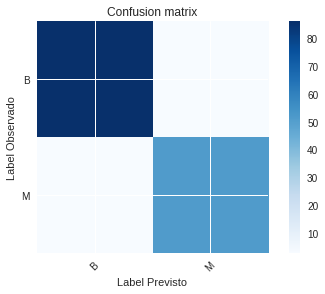

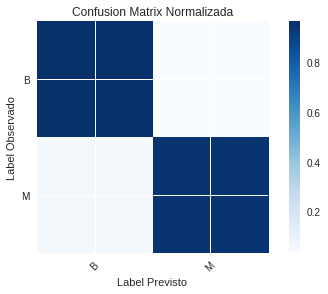

In [5]:
import numpy as np

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# Confusion matrix
cm = confusion_matrix(y_compare, pred)
np.set_printoptions(precision=2)
print('Confusion Matrix Sem Normalização')
print(cm)
plt.figure()
plot_confusion_matrix(cm, diagnosis)

# Normaliza a matriz de confusão por linha (ou seja, pelo número de amostras em cada classe)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Confusion Matrix Normalizada')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, diagnosis, title='Confusion Matrix Normalizada')

plt.show()

As duas matrizes de confusão acima mostram a mesma rede. A parte inferior (normalizada) é o tipo que você verá normalmente. Observe os dois rótulos. O rótulo "B" significa benigno (sem câncer) e o rótulo "M" significa maligno (câncer). O eixo x são as previsões e o eixo y são os resultados esperados. Um modelo perfeito (que nunca cometeu um erro) possui uma diagonal azul escuro que corre da parte superior esquerda para a parte inferior direita.

Para ler, considere o quadrado superior esquerdo. Este quadrado indica "verdadeiro rotulado" de B e também "rótulo previsto" de B. Isso é bom! A previsão corresponde à verdade. O azul desta caixa representa a frequência com que "B" é classificado corretamente. Não é azul escuro. Isso ocorre porque o quadrado à direita (que está fora da diagonal perfeita) tem alguma cor. Este quadrado indica a verdade de "B", mas a previsão de "M". O quadrado branco, na parte inferior esquerda, indica uma verdade de "M", mas previu de "B". A brancura indica que isso raramente acontece.

Sua conclusão do gráfico acima é que o modelo às vezes classifica "B" como "M" (um falso negativo), mas nunca classifica "M" como "B". Procure sempre a diagonal escura, isso é bom!

## Curva ROC 

As curvas ROC podem ser um pouco confusas. No entanto, eles são muito comuns. É importante saber como interpretá-las. O título Curva ROC vem de Engenharia Elétrica.

A classificação binária é comum em testes médicos. Muitas vezes você quer diagnosticar se alguém tem uma doença. Isso pode levar a dois tipos de erros, conhecidos como falsos positivos e falsos negativos:

* **False Positive** - Seu teste (rede neural) indicou que o paciente tinha a doença; No entanto, o paciente não teve a doença.
* **False Negative** - Seu teste (rede neural) indicou que o paciente não teve a doença; No entanto, o paciente teve a doença.
* **True Positive** - Seu teste (rede neural) identificou corretamente que o paciente tinha a doença.
* **True Negative** - Seu teste (rede neural) identificou corretamente que o paciente não tinha a doença.

Tipos de Erros:

![Tipos de Erros](https://github.com/vladimiralencar/DeepLearning-LANA/blob/master/DNN/images/errors.png?raw=true "Tipos de Erros")

As redes neurais classificam em termos de probabilidade de ser positivo. No entanto, em que probabilidade você dá um resultado positivo? O limite é de 50%? 90%? Onde você define esse ponto de corte é chamado de limite. Qualquer coisa acima do ponto de corte é positiva, qualquer coisa abaixo é negativa. Definir esse ponto de corte permite que o modelo seja mais sensível ou específico:

![Sensitivity vs. Specificity](https://github.com/vladimiralencar/DeepLearning-LANA/blob/master/DNN/images/t1vst2.png?raw=true  "Sensitivity vs. Specificity")

O seguinte mostra um ponto de corte mais sensível:

![Sensitive Cutoff ](https://github.com/vladimiralencar/DeepLearning-LANA/blob/master/DNN/images/spec_cut.png?raw=true "Sensitive Cutoff")

** Uma curva ROC mede o quão bom é um modelo, independentemente do ponto de corte. ** O seguinte mostra como ler um gráfico ROC:


![Reading a ROC Chart](https://github.com/vladimiralencar/DeepLearning-LANA/blob/master/DNN/images/roc.png?raw=true "Reading a ROC Chart")

O código a seguir mostra uma Curva ROC para a rede neural de câncer de mama. A área sob a curva (AUC) também é uma medida importante. Quanto maior a AUC, melhor.

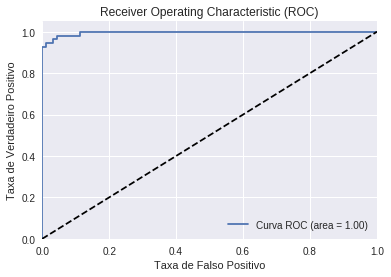

In [6]:
pred = model.predict(x_test)
pred = pred[:,1] # Somente casos positivos
plot_roc(pred,y_compare)

## Classificação Multiclasse

Já vimos a classificação multiclasse, com o conjunto de dados íris. As matrizes de confusão funcionam bem com 3 classes. O código a seguir gera uma matriz de confusão para a íris.

In [7]:
import pandas as pd
import io
import requests
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn import metrics
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.callbacks import EarlyStopping

path = "./data/"
    
filename = os.path.join(path,"iris.csv")    
df = pd.read_csv(filename,na_values=['NA','?'])

species = encode_text_index(df,"species")
x,y = to_xy(df,"species")

# Split em treino/teste
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

model = Sequential()
model.add(Dense(10, input_dim=x.shape[1], kernel_initializer='normal', activation='relu'))
model.add(Dense(1, kernel_initializer='normal'))
model.add(Dense(y.shape[1],activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
model.fit(x,y,validation_data=(x_test,y_test),callbacks=[monitor],verbose=0,epochs=1000)

Epoch 00524: early stopping


Agora vamos plotar o resultado e avaliá-lo!

['Iris-setosa' 'Iris-versicolor' 'Iris-virginica']
Confusion Matrix Sem Normalização
[[15  0  0]
 [ 0 11  0]
 [ 0  0 12]]
Confusion Matrix Normalizada
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


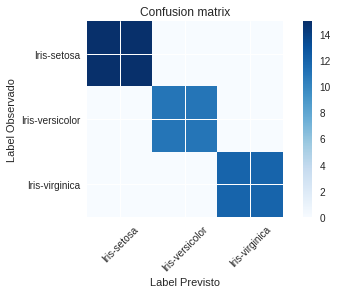

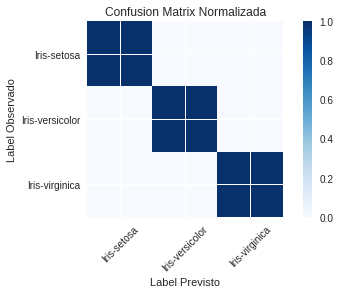

In [8]:
import numpy as np

from sklearn import svm, datasets
from sklearn.metrics import confusion_matrix

pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_test2 = np.argmax(y_test,axis=1)
    
# Confusion matrix
cm = confusion_matrix(y_test2, pred)
np.set_printoptions(precision=2)
print(species)
print('Confusion Matrix Sem Normalização')
print(cm)
plt.figure()
plot_confusion_matrix(cm, species)

# Normaliza a matriz de confusão por linha (ou seja, pelo número de amostras em cada classe)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Confusion Matrix Normalizada')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, species, title='Confusion Matrix Normalizada')


plt.show()

Percebeu diagonal forte? Veja o azul claro perto do fundo. Às vezes, virginica é confundida como versicolor.

## Regressão

Já vimos regressão com o conjunto de dados MPG. A regressão usa seu próprio conjunto de visualizações, uma das mais comuns é o gráfico de elevação (Lift Curve). O código a seguir gera um gráfico de elevação.

Epoch 00142: early stopping
Score (RMSE): 2.8801822662353516
r2: 0.8458354648620011


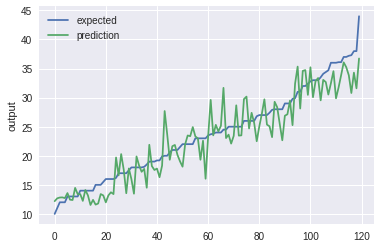

In [9]:
%matplotlib inline
from matplotlib.pyplot import figure, show
from sklearn.model_selection import train_test_split
import pandas as pd
import os
import numpy as np
from sklearn import metrics
from scipy.stats import zscore
import tensorflow as tf
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.callbacks import EarlyStopping


path = "./data/"
preprocess = False

filename_read = os.path.join(path,"auto-mpg.csv")
df = pd.read_csv(filename_read,na_values=['NA','?'])

# Vetor de features
missing_median(df, 'horsepower')
encode_text_dummy(df, 'origin')
df.drop('name',1,inplace=True)

# Normalização
if preprocess:
    encode_numeric_zscore(df, 'horsepower')
    encode_numeric_zscore(df, 'weight')
    encode_numeric_zscore(df, 'cylinders')
    encode_numeric_zscore(df, 'displacement')
    encode_numeric_zscore(df, 'acceleration')

# Dados de treino
x,y = to_xy(df,'mpg')

# Split em treino/teste
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=42)

model = Sequential()
model.add(Dense(10, input_dim=x.shape[1], kernel_initializer='normal', activation='relu'))
model.add(Dense(10, kernel_initializer='normal', activation='relu')) # add
#model.add(Dense(10, kernel_initializer='normal', activation='relu')) # add
model.add(Dense(1, kernel_initializer='normal'))
model.compile(loss='mean_squared_error', optimizer='adam')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
model.fit(x,y,validation_data=(x_test,y_test),callbacks=[monitor],verbose=0,epochs=2000)

# Previsões e RMSE
pred = model.predict(x_test)
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Score (RMSE): {}".format(score))

r2 = metrics.r2_score(pred,y_test)
print("r2:", r2)

# Plot 
chart_regression(pred.flatten(),y_test)

In [10]:
r2 = metrics.regression.r2_score(pred,y_test)

print("r2:", r2)

r2: 0.8458354648620011


In [0]:
Epoch 00111: early stopping
Score (RMSE): 2.7661826610565186
    
Epoch 00195: early stopping
Score (RMSE): 2.7059693336486816

Lendo um gráfico de elevação:

* As linhas com valores esperados e previstos devem estar próximas. Observe onde uma está acima da outra.
* O gráfico acima é mais preciso quando o MPG é mais baixo.
* À medida que aumenta o valor de MPG, aumenta a diferença entre valores previstos e observados. Provavelmente temos que revisar nosso procedimento de normalização.